/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  i

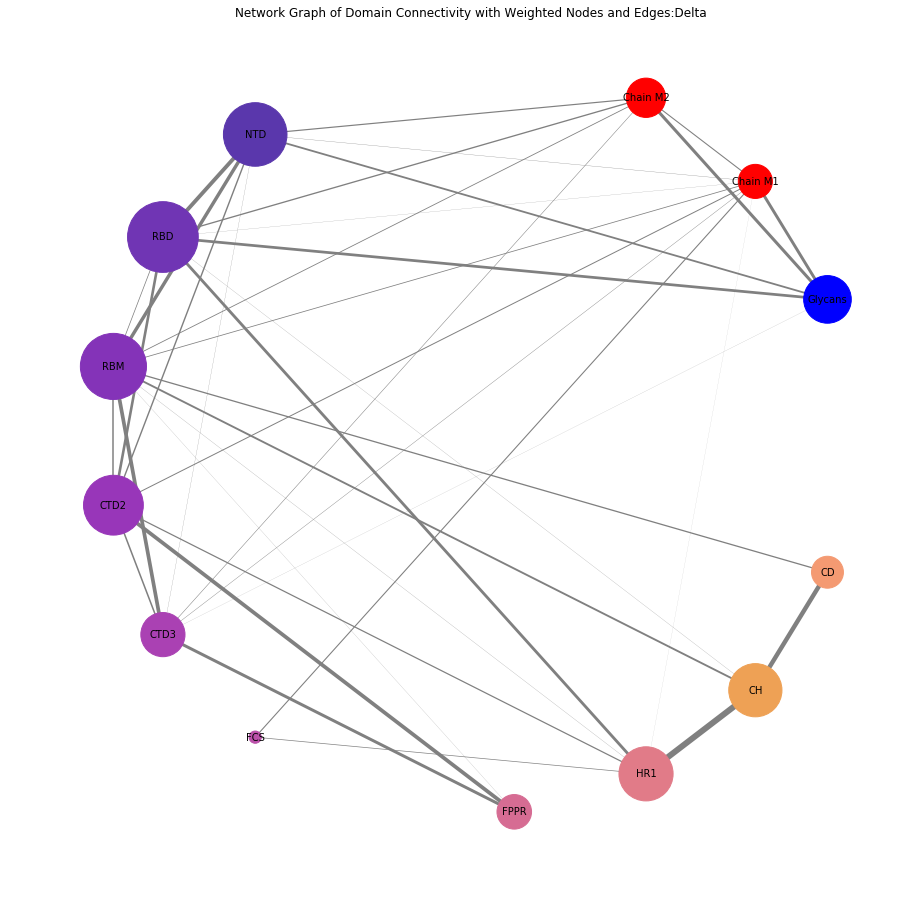

In [21]:
##CORRECT NUMBERS FOR DELTA 

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges

# Function to read PDB data
def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6:
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue for DELTA
def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(0, 276)).union(range(1126, 1402)).union(range(2252, 2528)),
        'RBD': set(range(316, 513)).union(range(1442, 1639)).union(range(2568, 2765)),
        'RBM': set(range(422, 493)).union(range(1548, 1619)).union(range(1674, 2751)),
        'CTD2': set(range(514, 574)).union(range(1640, 1701)).union(range(2766, 2827)),
        'CTD3': set(range(575, 660)).union(range(676, 682)).union(range(1701, 1786)).union(range(1802, 1808)).union(range(2827, 2912)).union(range(2928, 2934)),
        'FCS': set(range(660, 675)).union(range(1786, 1801)).union(range(2912, 2927)),
        'FP': set(range(802, 819)).union(range(1928, 1945)).union(range(3054, 3072)),
        'FPPR': set(range(820, 840)).union(range(1946, 1966)).union(range(3072, 3092)),
        'HR1': set(range(895, 970)).union(range(2023, 2096)).union(range(3147, 3222)),
        'CH': set(range(970, 1019)).union(range(2096, 2145)).union(range(3222, 3271)),
        'CD': set(range(1020, 1053)).union(range(2146, 2179)).union(range(3272, 3305)),
        'Glycans': range(3378, 3846),
       # 'Chain M MM1': range(3847, 3965),
       # 'Chain N MM1': range(4386, 4504),
       # 'Chain O MM1': range(4505, 4623),
       # 'Chain P MM2': range(3966, 4105),
       # 'Chain Q MM2': range(4246, 4385),
       # 'Chain R MM2': range(4106, 4245) 
     #   'Mucins': range(3847, 4623)
        'Chain M1': set(range(3847, 3965)).union(range(4386, 4504)).union(range(4505, 4623)),
        'Chain M2': set(range(3966, 4105)).union(range(4246, 4385)).union(range(4106, 4245))
   }

    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

# Function to calculate domain connectivity with uniform weights
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(float))
    total_weights = defaultdict(float)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += weight
            domain_connections[domain2][domain1] += weight  # Make it symmetric
            total_weights[domain1] += weight
            total_weights[domain2] += weight

    # Normalize the weights to make them uniform
    for domain1 in domain_connections:
        for domain2 in domain_connections[domain1]:
            domain_connections[domain1][domain2] /= (total_weights[domain1] + total_weights[domain2])

    return domain_connections, total_weights

# Function to create a circular layout
def circular_layout(G, order):
    pos = {}
    angle = 2 * math.pi / len(order)
    for i, node in enumerate(order):
        theta = i * angle
        pos[node] = (math.cos(theta), math.sin(theta))
    return pos

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights):
    G = nx.Graph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with normalized weights
    for domain1, connections in domain_connections.items():
        for domain2, weight in connections.items():
            if domain1 != domain2:
                G.add_edge(domain1, domain2, weight=weight)
    
    # Define the custom order of nodes
    node_order = [
       'Mucins','Glycans', 'Chain M1', 'Chain M2', 'Mucins', 'Mucins', 'NTD', 'RBD', 'RBM', 'CTD2', 'CTD3', 'FCS', 'FP', 'FPPR', 
        'HR1', 'CH', 'CD'
    ]
    
    # Use the circular layout
    pos = circular_layout(G, node_order)
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [5000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by normalized weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [6 * (weight / max_edge_weight) for weight in edge_weights.values()]

    # Define colors for each domain
    domain_colors = {
        'NTD': '#5A37AC',
        'RBD': '#7035B4',
        'RBM': '#8433B8',  # Light blue
        'CTD2': '#9836B9',
        'CTD3': '#AA41B3',
        'FCS': '#BB50AA',
        'FP': '#CA5D9F',
        'FPPR': '#D66C93',
        'HR1': '#E17B88',
        'CH': '#EEA155',
        'CD': '#F49A72',
        'Glycans': 'blue',
        'Chain M1': 'red',
        'Chain M2': 'red',
        'Chain M MM1': 'red',
        'Chain N MM1': 'red',
        'Chain O MM1': 'red',
        'Chain P MM2': 'red',
        'Chain Q MM2': 'red',
        'Chain R MM2': 'red',
        'Mucins': 'red'
    }

    node_colors = [domain_colors.get(domain, 'black') for domain in G.nodes()]

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10, 
            edge_color='gray', width=edge_widths)
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges:Delta')
    plt.show()

# Example usage:
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/edge_all_delta.txt")  # Your edge data
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined_delta.pdb")  # Your PDB data
domain_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights)


/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consist

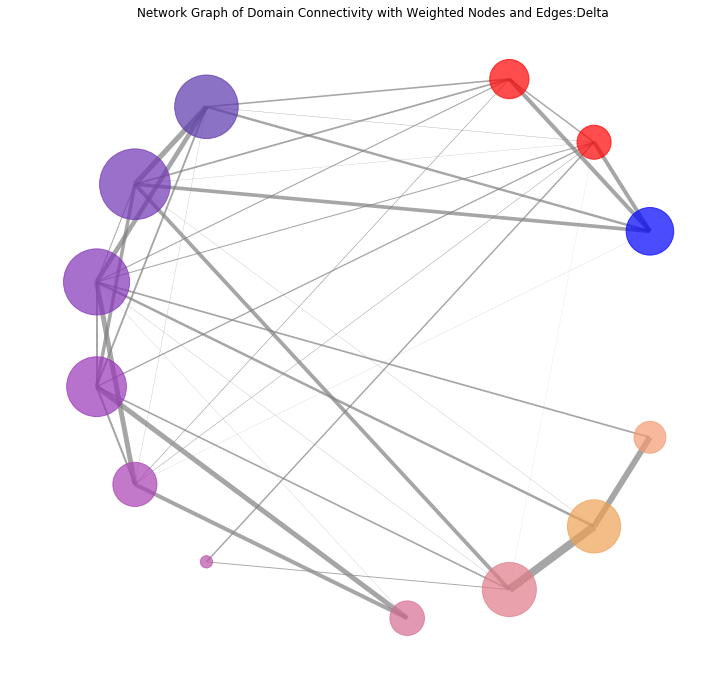

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges

# Function to read PDB data
def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6:
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue for DELTA
def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(0, 276)).union(range(1126, 1402)).union(range(2252, 2528)),
        'RBD': set(range(316, 513)).union(range(1442, 1639)).union(range(2568, 2765)),
        'RBM': set(range(422, 493)).union(range(1548, 1619)).union(range(1674, 2751)),
        'CTD2': set(range(514, 574)).union(range(1640, 1701)).union(range(2766, 2827)),
        'CTD3': set(range(575, 660)).union(range(676, 682)).union(range(1701, 1786)).union(range(1802, 1808)).union(range(2827, 2912)).union(range(2928, 2934)),
        'FCS': set(range(660, 675)).union(range(1786, 1801)).union(range(2912, 2927)),
        'FP': set(range(802, 819)).union(range(1928, 1945)).union(range(3054, 3072)),
        'FPPR': set(range(820, 840)).union(range(1946, 1966)).union(range(3072, 3092)),
        'HR1': set(range(895, 970)).union(range(2023, 2096)).union(range(3147, 3222)),
        'CH': set(range(970, 1019)).union(range(2096, 2145)).union(range(3222, 3271)),
        'CD': set(range(1020, 1053)).union(range(2146, 2179)).union(range(3272, 3305)),
        'Glycans': range(3378, 3846),
        'Chain M1': set(range(3847, 3965)).union(range(4386, 4504)).union(range(4505, 4623)),
        'Chain M2': set(range(3966, 4105)).union(range(4246, 4385)).union(range(4106, 4245))
   }

    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

# Function to calculate domain connectivity with uniform weights
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(float))
    total_weights = defaultdict(float)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += weight
            domain_connections[domain2][domain1] += weight  # Make it symmetric
            total_weights[domain1] += weight
            total_weights[domain2] += weight

    # Normalize the weights to make them uniform
    for domain1 in domain_connections:
        for domain2 in domain_connections[domain1]:
            domain_connections[domain1][domain2] /= (total_weights[domain1] + total_weights[domain2])

    return domain_connections, total_weights

# Function to create a circular layout
def circular_layout(G, order):
    pos = {}
    angle = 2 * math.pi / len(order)
    for i, node in enumerate(order):
        theta = i * angle
        pos[node] = (math.cos(theta), math.sin(theta))
    return pos

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights):
    G = nx.Graph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with normalized weights
    for domain1, connections in domain_connections.items():
        for domain2, weight in connections.items():
            if domain1 != domain2:
                G.add_edge(domain1, domain2, weight=weight)
    
    # Define the custom order of nodes
    node_order = [
       'Mucins','Glycans', 'Chain M1', 'Chain M2', 'Mucins', 'Mucins', 'NTD', 'RBD', 'RBM', 'CTD2', 'CTD3', 'FCS', 'FP', 'FPPR', 
        'HR1', 'CH', 'CD'
    ]
    
    # Use the circular layout
    pos = circular_layout(G, node_order)
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [5000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by normalized weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [8 * (weight / max_edge_weight) for weight in edge_weights.values()]

    # Define colors for each domain
    domain_colors = {
        'NTD': '#5A37AC',
        'RBD': '#7035B4',
        'RBM': '#8433B8',  # Light blue
        'CTD2': '#9836B9',
        'CTD3': '#AA41B3',
        'FCS': '#BB50AA',
        'FP': '#CA5D9F',
        'FPPR': '#D66C93',
        'HR1': '#E17B88',
        'CH': '#EEA155',
        'CD': '#F49A72',
        'Glycans': 'blue',
        'Chain M1': 'red',
        'Chain M2': 'red',
        'Mucins': 'red'
    }

    node_colors = [domain_colors.get(domain, 'black') for domain in G.nodes()]

    plt.figure(figsize=(12, 12))
    plt.gca().set_facecolor('none')  # Remove the white background
    nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, font_size=10, 
            edge_color='gray', width=edge_widths, alpha=0.7, edgecolors='black')  # Add transparency and solid line around nodes
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges:Delta')
    plt.show()

# Example usage:
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/edge_all_delta.txt")  # Your edge data
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined_delta.pdb")  # Your PDB data
domain_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights)


/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consist

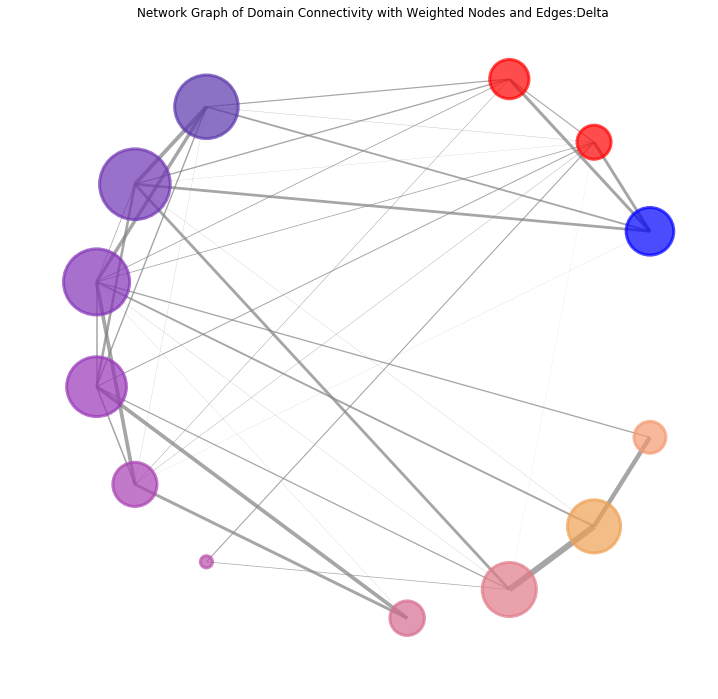

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# (Previous functions remain unchanged)

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights, node_border_width=2.0):
    G = nx.Graph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with normalized weights
    for domain1, connections in domain_connections.items():
        for domain2, weight in connections.items():
            if domain1 != domain2:
                G.add_edge(domain1, domain2, weight=weight)
    
    # Define the custom order of nodes
    node_order = [
       'Mucins','Glycans', 'Chain M1', 'Chain M2', 'Mucins', 'Mucins', 'NTD', 'RBD', 'RBM', 'CTD2', 'CTD3', 'FCS', 'FP', 'FPPR', 
        'HR1', 'CH', 'CD'
    ]
    
    # Use the circular layout
    pos = circular_layout(G, node_order)
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [5000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by normalized weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [6 * (weight / max_edge_weight) for weight in edge_weights.values()]

    # Define colors for each domain
    domain_colors = {
        'NTD': '#5A37AC',
        'RBD': '#7035B4',
        'RBM': '#8433B8',  # Light blue
        'CTD2': '#9836B9',
        'CTD3': '#AA41B3',
        'FCS': '#BB50AA',
        'FP': '#CA5D9F',
        'FPPR': '#D66C93',
        'HR1': '#E17B88',
        'CH': '#EEA155',
        'CD': '#F49A72',
        'Glycans': 'blue',
        'Chain M1': 'red',
        'Chain M2': 'red',
        'Mucins': 'red'
    }

    node_colors = [domain_colors.get(domain, 'black') for domain in G.nodes()]

    plt.figure(figsize=(12, 12))
    plt.gca().set_facecolor('none')  # Remove the white background
    nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, font_size=10, 
            edge_color='gray', width=edge_widths, alpha=0.7, edgecolors='black', linewidths=node_border_width)  # Add transparency and solid line around nodes with controlled width
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges:Delta')
    plt.show()

# Example usage:
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/edge_all_delta.txt")  # Your edge data
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined_delta.pdb")  # Your PDB data
domain_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights, node_border_width=3.0)  # Adjust the border width as needed
